In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取降水数据
precip_path = r"C:\Users\Shaira\Desktop\china_precipitation_province_annual_total_2018_2024.csv"
precip = pd.read_csv(precip_path)

# 读取粮食产量数据并转为长格式
grain_path = r"C:\Users\Shaira\Desktop\grain.xlsx"
grain = pd.read_excel(grain_path)
grain_long = grain.melt(id_vars="province", var_name="year", value_name="grain_output")

# year列转int，方便合并
grain_long["year"] = grain_long["year"].astype(int)

# 合并两个数据集
data = pd.merge(precip, grain_long, on=["province", "year"])

# 添加分组信息
group_dict = {
    "领先型": ["山东", "安徽", "江西", "江苏", "湖南", "新疆"],
    "发展型": ["河北", "河南", "内蒙古", "黑龙江", "陕西", "宁夏", "辽宁"],
    "追赶型": ["山西", "湖北", "吉林", "四川", "云南", "广西", "浙江", "重庆", "海南"],
    "起步型": ["贵州", "青海", "西藏", "甘肃", "广西"]
}

# 映射分组
def get_group(province):
    for group, provinces in group_dict.items():
        if province in provinces:
            return group
    return None  # 没分组的标记为 None

data["group"] = data["province"].apply(get_group)

# 删除未分组的省份
data = data[data["group"].notna()].reset_index(drop=True)


<Figure size 1200x800 with 0 Axes>

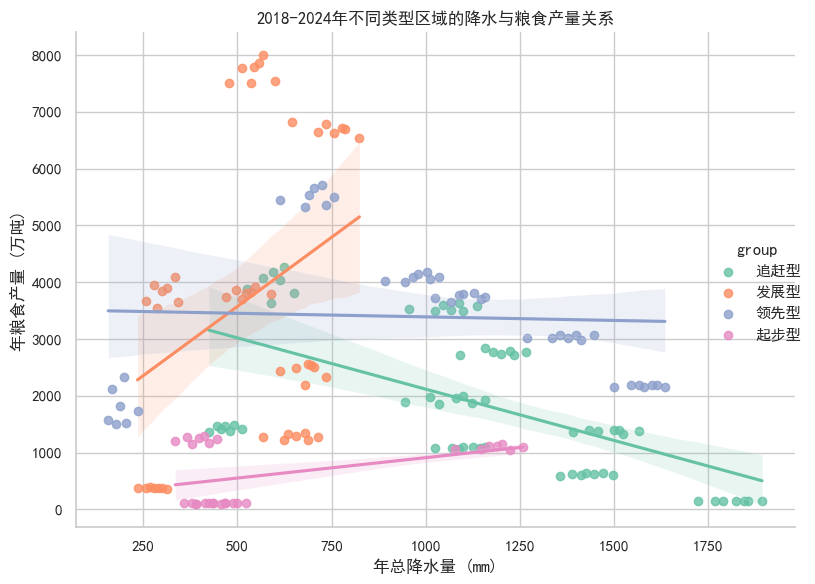

In [20]:
plt.figure(figsize=(12, 8))
sns.lmplot(
    data=data,
    x="annual_total_precipitation",
    y="grain_output",
    hue="group",
    palette="Set2",
    height=6,
    aspect=1.2
)
plt.xlabel("年总降水量 (mm)")
plt.ylabel("年粮食产量 (万吨)")
plt.title("2018-2024年不同类型区域的降水与粮食产量关系")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

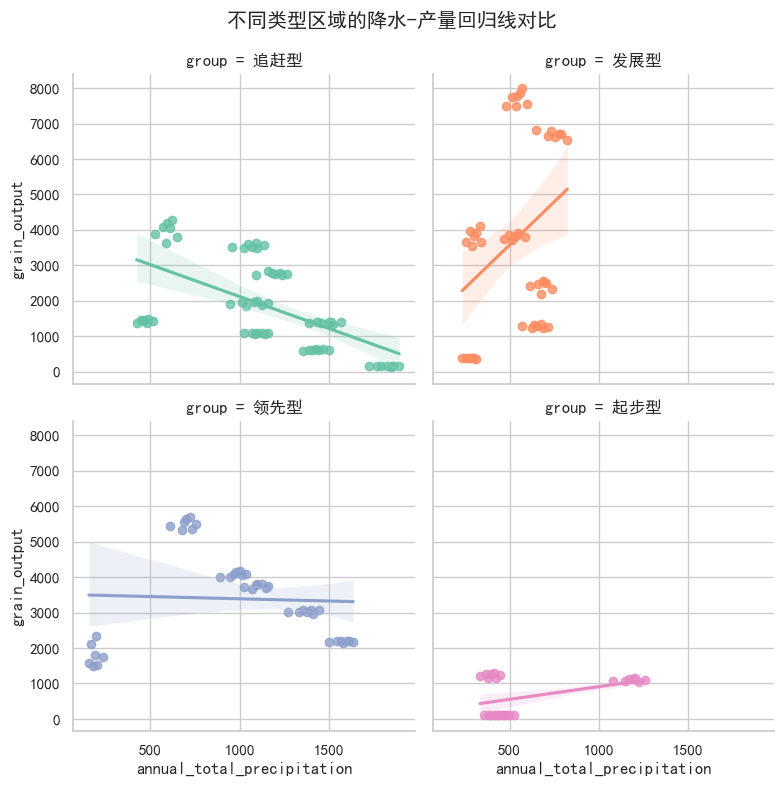

In [22]:
plt.figure(figsize=(10, 6))
sns.lmplot(
    data=data,
    x="annual_total_precipitation",
    y="grain_output",
    col="group",
    hue="group",
    palette="Set2",
    col_wrap=2,
    height=4,
    aspect=1
)
plt.subplots_adjust(top=0.9)
plt.suptitle("不同类型区域的降水-产量回归线对比")
plt.show()


In [23]:
# 构造虚拟变量
data["group_dummy"] = data["group"].apply(lambda x: 1 if x == "领先型" else 0)

# 交互项模型
model_all = smf.ols("grain_output ~ annual_total_precipitation * group_dummy", data=data).fit()
print(model_all.summary())


                            OLS Regression Results                            
Dep. Variable:           grain_output   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     6.520
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           0.000329
Time:                        23:56:26   Log-Likelihood:                -1629.1
No. Observations:                 182   AIC:                             3266.
Df Residuals:                     178   BIC:                             3279.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

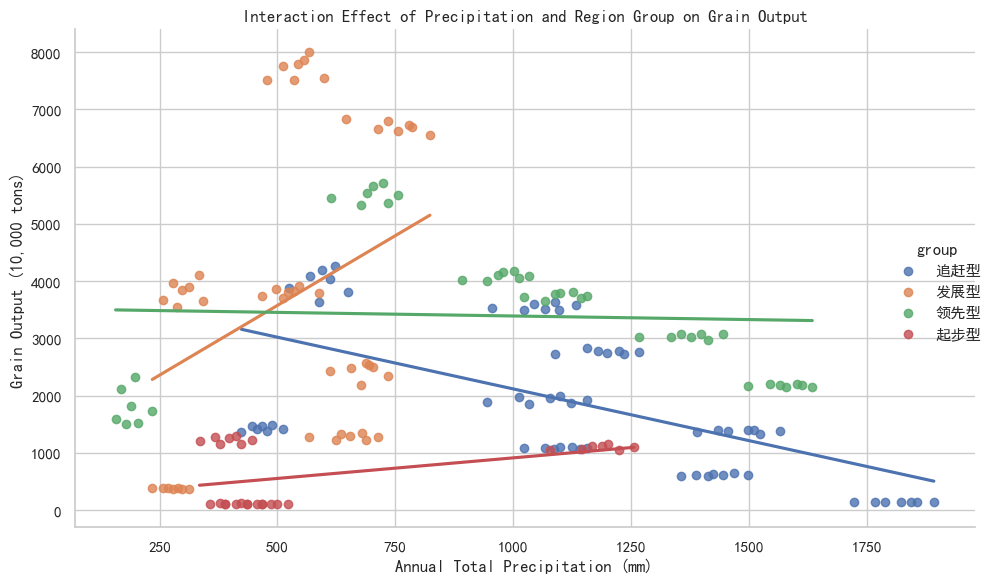

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# 画回归线，区分组别
sns.lmplot(
    x="annual_total_precipitation",
    y="grain_output",
    hue="group",
    data=data,
    aspect=1.5,
    ci=None,
    height=6
)

plt.title("降水量和不同类型区域对粮食产量的交互影响")
plt.xlabel("Annual Total Precipitation (mm)")
plt.ylabel("Grain Output (10,000 tons)")
plt.tight_layout()
plt.show()


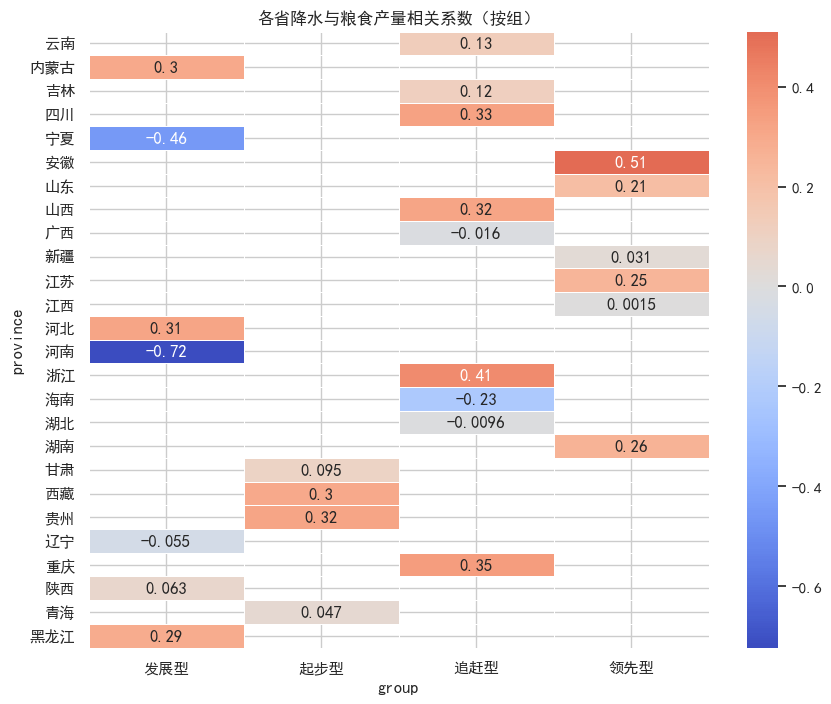

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题


# 计算每个省的降水和产量相关系数
corr_list = []
for prov in data["province"].unique():
    sub = data[data["province"]==prov]
    corr = sub["annual_total_precipitation"].corr(sub["grain_output"])
    group = sub["group"].iloc[0]
    corr_list.append({"province": prov, "group": group, "corr": corr})

corr_df = pd.DataFrame(corr_list)

# 透视表：行是省，列是组（重复省没关系，行省名）
pivot = corr_df.pivot(index="province", columns="group", values="corr")

# 画热力图
plt.figure(figsize=(10,8))
sns.heatmap(corr_df.pivot_table(index='province', columns='group', values='corr', aggfunc='first'),
            annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("各省降水与粮食产量相关系数（按组）")
plt.show()

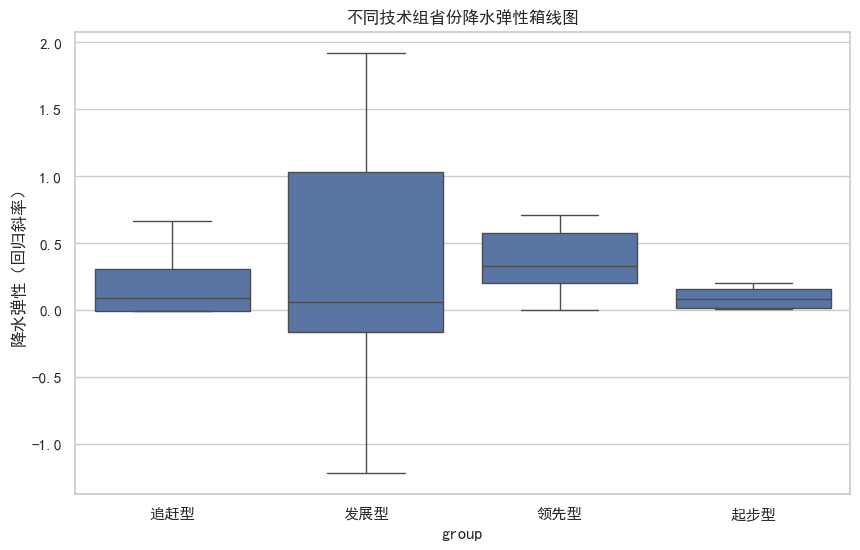

In [37]:
import statsmodels.api as sm

# 省级回归，提取斜率
elasticity_list = []
for prov in data["province"].unique():
    sub = data[data["province"]==prov]
    X = sm.add_constant(sub["annual_total_precipitation"])
    y = sub["grain_output"]
    model = sm.OLS(y, X).fit()
    slope = model.params["annual_total_precipitation"]
    group = sub["group"].iloc[0]
    elasticity_list.append({"province": prov, "group": group, "elasticity": slope})

elasticity_df = pd.DataFrame(elasticity_list)

# 画箱线图
plt.figure(figsize=(10,6))
sns.boxplot(x="group", y="elasticity", data=elasticity_df)
plt.title("不同技术组省份降水弹性箱线图")
plt.ylabel("降水弹性（回归斜率）")
plt.show()


In [21]:
import statsmodels.formula.api as smf

# 输出每组的线性回归结果
for g in data["group"].unique():
    print(f"\n--- {g} 区域回归 ---")
    df = data[data["group"] == g]
    model = smf.ols("grain_output ~ annual_total_precipitation", data=df).fit()
    print(model.summary())



--- 追赶型 区域回归 ---
                            OLS Regression Results                            
Dep. Variable:           grain_output   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     31.78
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           4.71e-07
Time:                        23:56:15   Log-Likelihood:                -524.69
No. Observations:                  63   AIC:                             1053.
Df Residuals:                      61   BIC:                             1058.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
In